In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

In [2]:
dataset = pd.read_csv('appdata10.csv')

# EDA

In [3]:
dataset.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [4]:
dataset.describe()

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Data cleaning
dataset['hour'] = dataset.hour.str.slice(1,3).astype(int)

In [6]:
# Plotting
dataset2 = dataset.copy().drop(columns = ['user', 'screen_list', 'enrolled_date', 'first_open','enrolled'])
dataset2.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


### Histogram

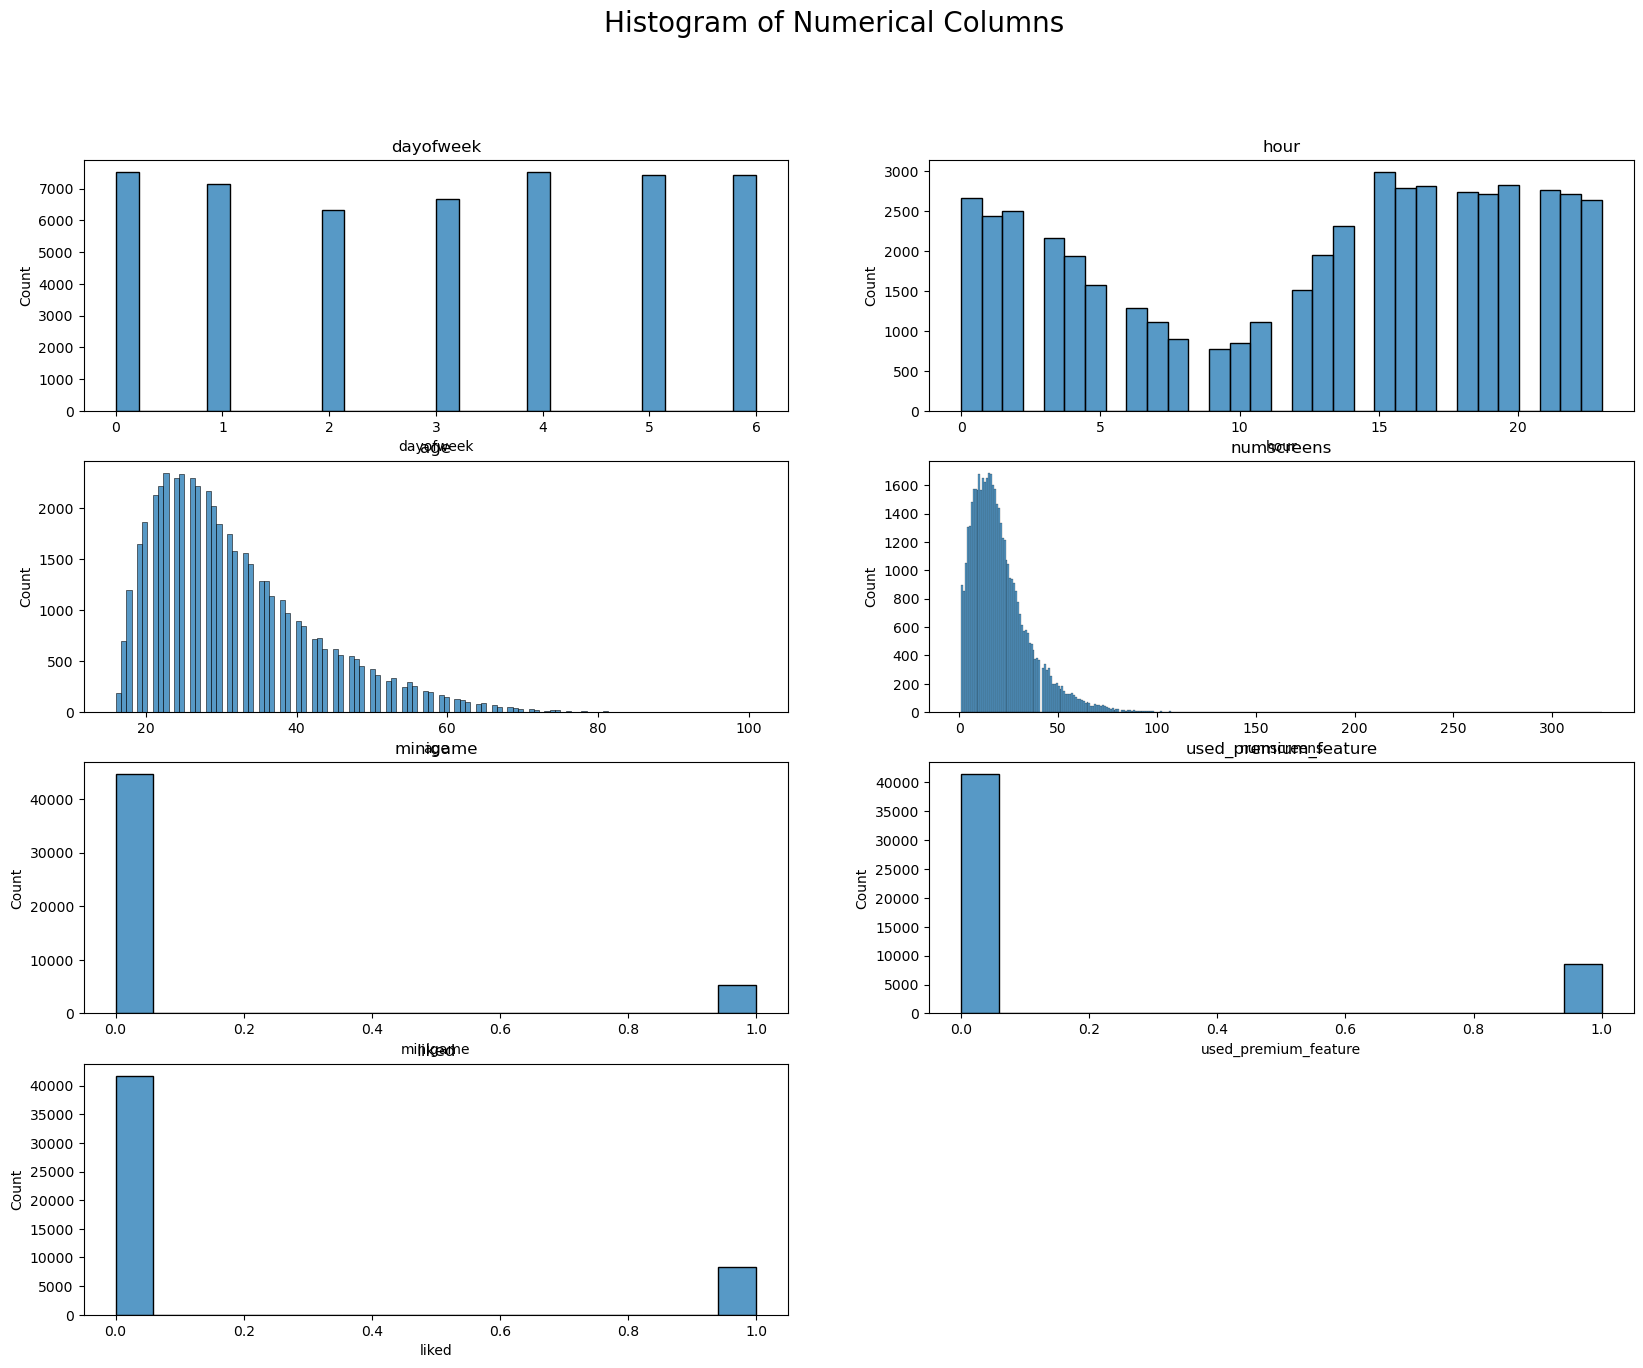

In [7]:
# Set the overall title for the plot
plt.figure(figsize=(20, 15)) 
plt.suptitle('Histogram of Numerical Columns', fontsize=20)

# Iterate over each column in the dataset to create a histogram for each
for i, column in enumerate(dataset2.columns, 1):
    plt.subplot(4, 2, i) 
    sns.histplot(dataset2[column], kde=False) 
    plt.title(column)

plt.savefig('histogram_of_numerical_columns.png')

plt.show()

### Correlation with response

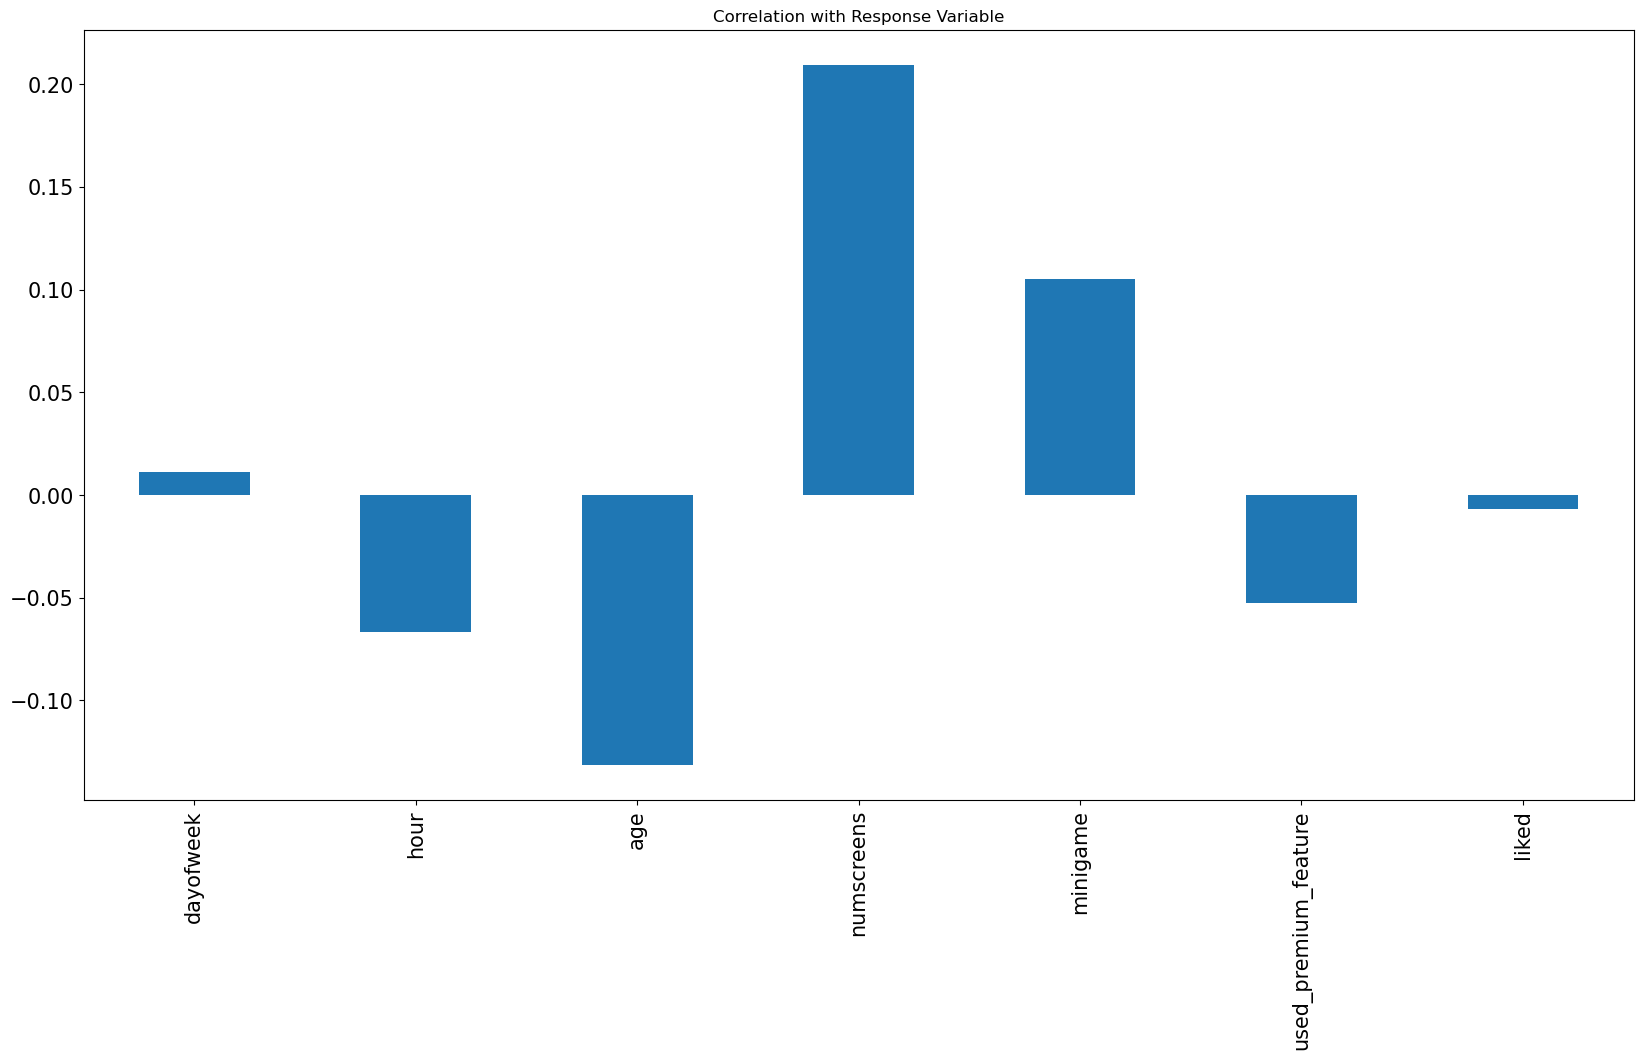

In [8]:
dataset2.corrwith(dataset.enrolled).plot.bar(figsize = (20,10),
                                            title = 'Correlation with Response Variable',
                                            fontsize = 15)

plt.savefig('correlation_with_response_variable.png') 

plt.show()


### Correlation Matrix

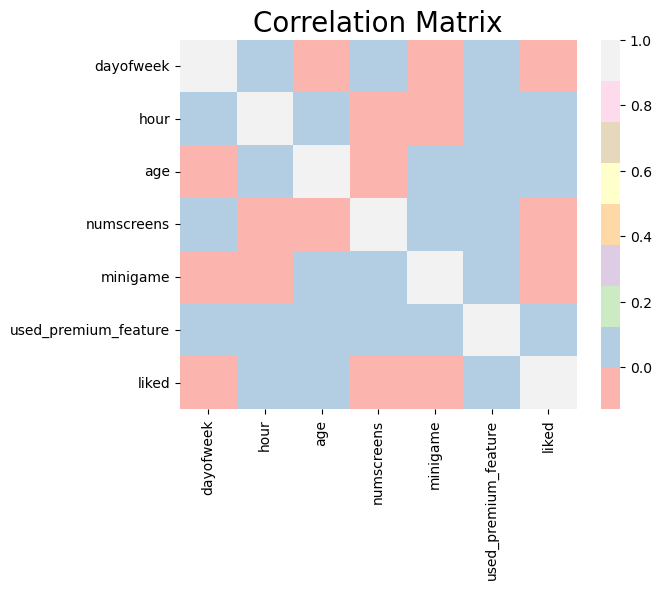

In [9]:
sns.heatmap(dataset2.corr(), color='steelblue', cmap='Pastel1')
plt.title('Correlation Matrix', fontsize = 20)

plt.savefig('correlation matrix.png') 

plt.show()

# Feature Engineering

In [10]:
dataset.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                     int64
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

In [11]:
dataset['first_open'] = [parser.parse(row_data) for row_data in dataset['first_open']]
dataset['enrolled_date'] = [parser.parse(row_data) if isinstance(row_data, str) else row_data for row_data in dataset['enrolled_date']]

In [12]:
dataset.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int64
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

In [13]:
dataset['difference'] = (dataset['enrolled_date'] - dataset['first_open']).dt.total_seconds() / (60 * 60)

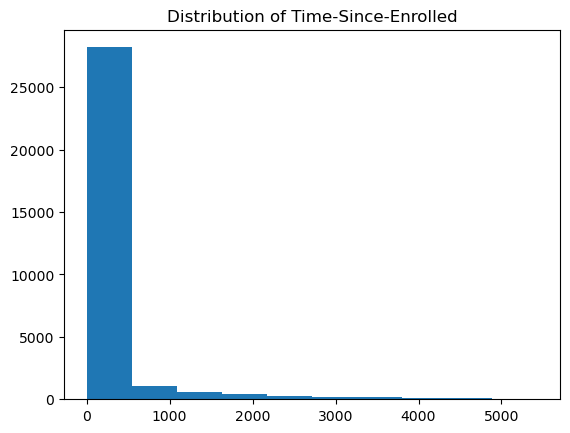

In [14]:
plt.hist(dataset['difference'].dropna())
plt.title('Distribution of Time-Since-Enrolled')

plt.savefig('distribution of time since enrollment.png') 

plt.show()

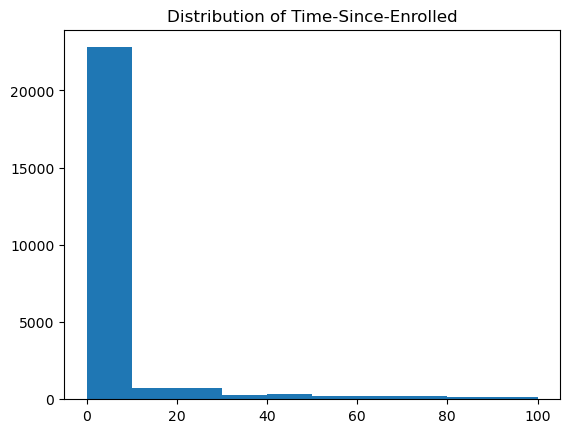

In [15]:
plt.hist(dataset['difference'].dropna(), range = [0,100])
plt.title('Distribution of Time-Since-Enrolled')

plt.savefig('distribution of time 100 hours since enrollment.png') 

plt.show()

In [16]:
# Most enrollment happens during the first 10 hours.
# Use 48 hours after first openning as a cut-off point for enrollment
dataset.loc[dataset.difference > 48, 'enrolled'] = 0

# Drop useless columns
dataset = dataset.drop(columns = ['difference', 'enrolled_date', 'first_open'])

#### Formatting the screen_list field

In [17]:
top_screens = pd.read_csv('top_screens.csv').top_screens.values

In [18]:
top_screens

array(['Loan2', 'location', 'Institutions', 'Credit3Container',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth',
       'ProfilePage', 'VerifyCountry', 'Cycle', 'idscreen',
       'Credit3Dashboard', 'Loan3', 'CC1Category', 'Splash', 'Loan',
       'CC1', 'RewardsContainer', 'Credit3', 'Credit1', 'EditProfile',
       'Credit2', 'Finances', 'CC3', 'Saving9', 'Saving1', 'Alerts',
       'Saving8', 'Saving10', 'Leaderboard', 'Saving4', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'Saving7', 'ProfileEducationMajor', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'VerifyIncomeType', 'Saving2', 'Saving6',
       'Saving2Amount', 'Saving5', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'Loan4',
       'ResendToken', 'TransactionList', 'NetworkFailure', 'ListPicker'],
      dtype=object)

In [19]:
dataset['screen_list'] = dataset.screen_list.astype(str) + ','

In [20]:
for sc in top_screens:
    dataset[sc] = dataset.screen_list.str.contains(sc).astype(int)
    dataset['screen_list'] = dataset.screen_list.str.replace(sc+',',' ')

In [21]:
dataset['other'] = dataset.screen_list.str.count(',')
dataset = dataset.drop(columns = ['screen_list'])

#### Funnels

In [22]:
# Some features arestrongly correlated, e.g. savings1, savings2; credit1, credit2
# Aggregate those columes into one to avoid multicollinearity.
savings_screens = list(dataset.columns[dataset.columns.str.contains('Saving')])
dataset['SavingsCount'] = dataset[savings_screens].sum(axis = 1)
dataset = dataset.drop(columns = savings_screens)

In [23]:
cm_screens = list(dataset.columns[dataset.columns.str.contains('Credit')])
dataset['CMCount'] = dataset[cm_screens].sum(axis = 1)
dataset = dataset.drop(columns = cm_screens)

In [24]:
cc_screens = list(dataset.columns[dataset.columns.str.contains('CC')])
dataset['CCCount'] = dataset[cc_screens].sum(axis = 1)
dataset = dataset.drop(columns = cc_screens)

In [25]:
loan_screens = list(dataset.columns[dataset.columns.str.contains('Loan')])
dataset['LoansCount'] = dataset[loan_screens].sum(axis = 1)
dataset = dataset.drop(columns = loan_screens)

In [26]:
dataset.describe()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,other,SavingsCount,CMCount,CCCount,LoansCount
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000
mean,186889.729900,3.029860,12.557220,31.72436,21.095900,0.107820,0.172020,0.495740,0.165000,0.517760,...,0.014220,0.013340,0.013400,0.008200,0.007580,6.214260,0.365020,0.92776,0.176860,0.788400
std,107768.520361,2.031997,7.438072,10.80331,15.728812,0.310156,0.377402,0.499987,0.371184,0.499689,...,0.118398,0.114727,0.114981,0.090183,0.086733,3.672561,1.405511,1.21751,0.612787,0.677462
min,13.000000,0.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,93526.750000,1.000000,5.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.00000,0.000000,0.000000
50%,187193.500000,3.000000,14.000000,29.00000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.00000,0.000000,1.000000
75%,279984.250000,5.000000,19.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.00000,0.000000,1.000000
max,373662.000000,6.000000,23.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,10.000000,5.00000,3.000000,3.000000


In [27]:
dataset.to_csv('new_appdata11.csv', index = False)

# Model Building

### Data Pre-processing

In [28]:
dataset = pd.read_csv('new_appdata11.csv')

In [29]:
dataset.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,other,SavingsCount,CMCount,CCCount,LoansCount
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,10,0,2,0,1


In [30]:
response = dataset['enrolled']
dataset = dataset.drop(columns = 'enrolled')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(dataset, response, test_size = 0.2)

In [32]:
train_identifier = X_train['user']
X_train = X_train.drop(columns = 'user')
test_identifier = X_test['user']
X_test = X_test.drop(columns = 'user')

### Feature Scaling

In [33]:
sc_X = StandardScaler()

In [34]:
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))

In [35]:
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values

In [36]:
X_train2.index = X_train.index.values
X_test2.index = X_test2.index.values

In [37]:
X_train = X_train2
X_test = X_test2

### Model Building

In [38]:
classifier = LogisticRegression(solver = 'liblinear', penalty = 'l1') # the screens can be correlated. The lasso penalizes particular fields that are strongly correlated with response variable.
classifier.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [39]:
y_pred = classifier.predict(X_test)

In [40]:
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.7671

In [41]:
precision_score(y_test, y_pred) # number of true positives / true positives + false positives

0.7565392354124748

In [42]:
recall_score(y_test, y_pred) # true positive / true positives + false negatives

0.7706497233039558

In [43]:
f1_score(y_test, y_pred)

0.7635292923139406

<Axes: >

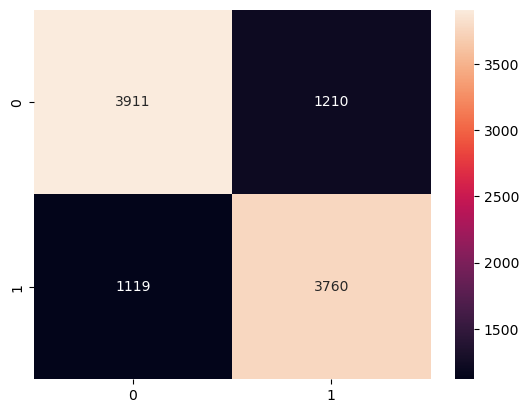

In [44]:
sns.heatmap(cm, annot = True, fmt = 'd')

In [45]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

In [46]:
print('Logistic Accuracy: %0.3f (+/- %0.3f)' % (accuracies.mean(), accuracies.std()*2)) # The model accuracy is consistent

Logistic Accuracy: 0.768 (+/- 0.011)


# Model Conclusion

In [47]:
# Formatting the final results
final_results = pd.concat([y_test, test_identifier], axis = 1).dropna()

In [48]:
final_results['predicted_results'] = y_pred

In [49]:
final_results[['user', 'enrolled', 'predicted_results']].reset_index(drop = True)

,user,enrolled,predicted_results
0,42663,1,0
1,141453,0,0
2,179538,0,0
3,186293,1,1
4,93962,0,0
...,...,...,...
9995,29540,0,0
9996,291702,1,1
9997,248707,0,0
9998,298584,1,0


- The model will label every new users as highly likely (or unlikely) to subscribe.
- We can further validate our results by running our predictions on daily new installs, and see whether the accuracy is consistent. 
- From there, we can narrow our marketing efforst only to those users unlikely to subscribe, and thus increase our subscription rate.